In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
import sys
sys.path.append('../../')

In [3]:
from codes.docs.analysis import graph_analysis, data_preprocessing

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

## Examining structural connectivity in neonates at genetic risk for schizophrenia

In [2]:
! ls preprocessed_data/preterm

AAL_label.npy
Imperial_GM_labels.npy
adjusted_european_GM_volumetric_Imperial_matrix.npy
adjusted_european_PRS_schizophrenia.npy
adjusted_european_volumetric_AAL_matrix.npy
adjusted_european_volumetric_Imperial_matrix.npy
european_PRS_schizophrenia.npy
european_age_at_scan.npy
european_gestational_age.npy
european_icv.npy


In [4]:
# importing the preprocessed data
adjusted_european_GM_volumetric_Imperial_matrix_preterm=np.load('./preprocessed_data/preterm/adjusted_european_GM_volumetric_Imperial_matrix.npy')
Imperial_GM_labels=np.load('./preprocessed_data/preterm/Imperial_GM_labels.npy',allow_pickle=True)
adjusted_european_volumetric_AAL_matrix_preterm=np.load('./preprocessed_data/preterm/adjusted_european_volumetric_AAL_matrix.npy',allow_pickle=True)
european_PRS_schizophrenia_preterm=np.load('./preprocessed_data/preterm/european_PRS_schizophrenia.npy',allow_pickle=True)
AAL_label=np.load('./preprocessed_data/preterm/AAL_label.npy',allow_pickle=True)

# importing the preprocessed data
european_PRS_schizophrenia_term=np.load('./preprocessed_data/term/european_PRS_schizophrenia.npy',allow_pickle=True)
adjusted_european_GM_volumetric_Imperial_matrix_term=np.load('./preprocessed_data/term/adjusted_european_GM_volumetric_Imperial_matrix.npy')
adjusted_european_volumetric_AAL_matrix_term=np.load('./preprocessed_data/term/adjusted_european_volumetric_AAL_matrix.npy',allow_pickle=True)

### 1.1 Imperial GM atlas

In [5]:
#Dividing the data set into high and low risk
#get the indices of the low and high risk
#preterm
low_risk_preterm,high_risk_preterm=data_preprocessing.high_low_risk_divide(european_PRS_schizophrenia_preterm[:,9],bins=100,percentage=0.3)
X_low_risk_preterm=adjusted_european_GM_volumetric_Imperial_matrix_preterm[low_risk_preterm,:]
X_high_risk_preterm=adjusted_european_GM_volumetric_Imperial_matrix_preterm[high_risk_preterm,:]
X_preterm=np.vstack((X_low_risk_preterm,X_high_risk_preterm))
X_preterm=StandardScaler().fit_transform(X_preterm)
y_preterm=np.concatenate((np.zeros(X_low_risk_preterm.shape[0]),np.ones(X_high_risk_preterm.shape[0])))
#term
low_risk_term,high_risk_term=data_preprocessing.high_low_risk_divide(european_PRS_schizophrenia_term[:,9],bins=100,percentage=0.3)
X_low_risk_term=adjusted_european_GM_volumetric_Imperial_matrix_term[low_risk_term,:]
X_high_risk_term=adjusted_european_GM_volumetric_Imperial_matrix_term[high_risk_term,:]
X_term=np.vstack((X_low_risk_term,X_high_risk_term))
X_term=StandardScaler().fit_transform(X_term)
y_term=np.concatenate((np.zeros(X_low_risk_term.shape[0]),np.ones(X_high_risk_term.shape[0])))

In [6]:
np.save('./preprocessed_data/preterm/high_low_risk_vol_Imperial_dataset.npy',X_preterm)
np.save('./preprocessed_data/term/high_low_risk_vol_Imperial_dataset.npy',X_term)

#### 1.2 Visualising data

In [7]:
#rearrange the matrix by side
right_indices=np.array([idx for idx,i in enumerate(Imperial_GM_labels) if 'right' in i])
print(right_indices.shape)
left_indices=np.array([idx for idx,i in enumerate(Imperial_GM_labels) if 'left' in i])
print(left_indices.shape)
neither_indices=np.array([idx for idx,i in enumerate(Imperial_GM_labels) if 'right' not in i and 'left' not in i])
rearrange_by_side_indices=np.concatenate((right_indices,left_indices,neither_indices),axis=0)

(25,)
(25,)


In [8]:
# calculating pearson correlation matrix of volumetric data
corrmatrix_low_risk_preterm=abs(np.corrcoef(X_preterm[y_preterm==0,:],rowvar=False))
np.fill_diagonal(corrmatrix_low_risk_preterm,0)
corrmatrix_high_risk_preterm=abs(np.corrcoef(X_preterm[y_preterm==1,:],rowvar=False))
np.fill_diagonal(corrmatrix_high_risk_preterm,0)

corrmatrix_low_risk_term=abs(np.corrcoef(X_term[y_term==0,:],rowvar=False))
np.fill_diagonal(corrmatrix_low_risk_term,0)
corrmatrix_high_risk_term=abs(np.corrcoef(X_term[y_term==1,:],rowvar=False))
np.fill_diagonal(corrmatrix_high_risk_term,0)


In [9]:
rearranged_corrmatrix_low_risk_preterm=np.asarray([[corrmatrix_low_risk_preterm[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_high_risk_preterm=np.asarray([[corrmatrix_high_risk_preterm[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_low_risk_term=np.asarray([[corrmatrix_low_risk_term[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_high_risk_term=np.asarray([[corrmatrix_high_risk_term[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

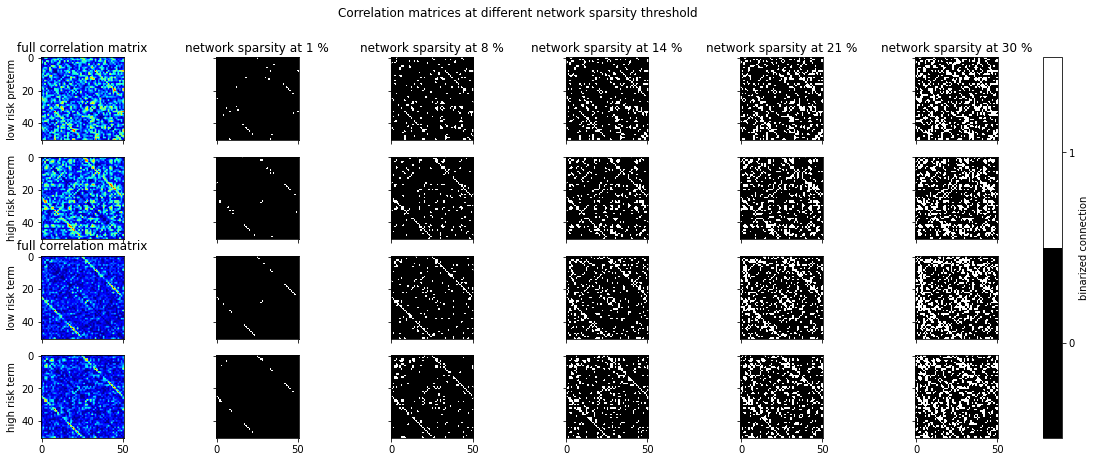

In [10]:
f,axes=plt.subplots(4,6,sharex=True,sharey=True,figsize=(20,7))
network_sparsity_threshold=[int(i) for i in (np.linspace(1,30,5))]
for idx,ax in enumerate(axes[0]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_low_risk_preterm,cmap='jet')
        ax.set_title('full correlation matrix')
        ax.set_ylabel('low risk preterm',fontsize=10)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_low_risk_preterm,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        ax.set_title('network sparsity at %d %%'%(len(np.where(data_preprocessing.lower_triangle(binarized_matrix)==1)[0])*100/(52*51/2)))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[1]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_high_risk_preterm,cmap='jet')
        ax.set_ylabel('high risk preterm',fontsize=10)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_high_risk_preterm,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

for idx,ax in enumerate(axes[2]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_low_risk_term,cmap='jet')
        ax.set_title('full correlation matrix')
        ax.set_ylabel('low risk term',fontsize=10)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_low_risk_term,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[3]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_high_risk_term,cmap='jet')
        ax.set_ylabel('high risk term',fontsize=10)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_high_risk_term,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

f.suptitle('Correlation matrices at different network sparsity threshold')
f.colorbar(im,ax=np.concatenate(axes),ticks=range(2),label='binarized connection',fraction=0.046, pad=0.04)

#### 1.3 Network metrics

In [11]:
#generate binarized matrices for over a range of network sparsity for high and low risk groups
binarized_low_risk_matrices_preterm=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_low_risk_preterm,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])
binarized_high_risk_matrices_preterm=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_high_risk_preterm,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])


binarized_low_risk_matrices_term=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_low_risk_term,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])
binarized_high_risk_matrices_term=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_high_risk_term,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])

In [16]:
#calculating graph_metrics_low_risk
# import tqdm

# for threshold in tqdm.tqdm(range(30)):
#     temp_path_low_risk='./preprocessed_data/preterm/graph_metrics_vol_low_risk_Imperial.txt'
#     low_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_low_risk_matrices[threshold],51))

#     with open(temp_path_low_risk,'ab') as f:
#         np.savetxt(f,np.asarray([low_risk_metrics]),delimiter='\t')

#     temp_path_high_risk='./preprocessed_data/preterm/graph_metrics_vol_high_risk_Imperial.txt'
#     high_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_high_risk_matrices[threshold],51))

#     with open(temp_path_high_risk,'ab') as n:
#         np.savetxt(n,np.asarray([high_risk_metrics]),delimiter='\t')


import tqdm

for threshold in tqdm.tqdm(range(30)):
    temp_path_low_risk='./preprocessed_data/term/graph_metrics_vol_low_risk_Imperial.txt'
    low_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_low_risk_matrices_term[threshold],51))

    with open(temp_path_low_risk,'ab') as f:
        np.savetxt(f,np.asarray([low_risk_metrics]),delimiter='\t')

    temp_path_high_risk='./preprocessed_data/term/graph_metrics_vol_high_risk_Imperial.txt'
    high_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_high_risk_matrices_term[threshold],51))

    with open(temp_path_high_risk,'ab') as n:
        np.savetxt(n,np.asarray([high_risk_metrics]),delimiter='\t')

100%|██████████| 30/30 [03:16<00:00,  6.54s/it]


#### 1.4 Permutation statistics

In [36]:
#run executable_script/perm_graph_network.py to calculate 1000 permuted network metrics.
obsv_high_preterm=np.loadtxt('./preprocessed_data/preterm/graph_metrics_vol_high_risk_Imperial.txt')
obsv_low_preterm=np.loadtxt('./preprocessed_data/preterm/graph_metrics_vol_low_risk_Imperial.txt')

obsv_high_term=np.loadtxt('./preprocessed_data/term/graph_metrics_vol_high_risk_Imperial.txt')
obsv_low_term=np.loadtxt('./preprocessed_data/term/graph_metrics_vol_low_risk_Imperial.txt')

Text(0, 0.5, 'Small world')

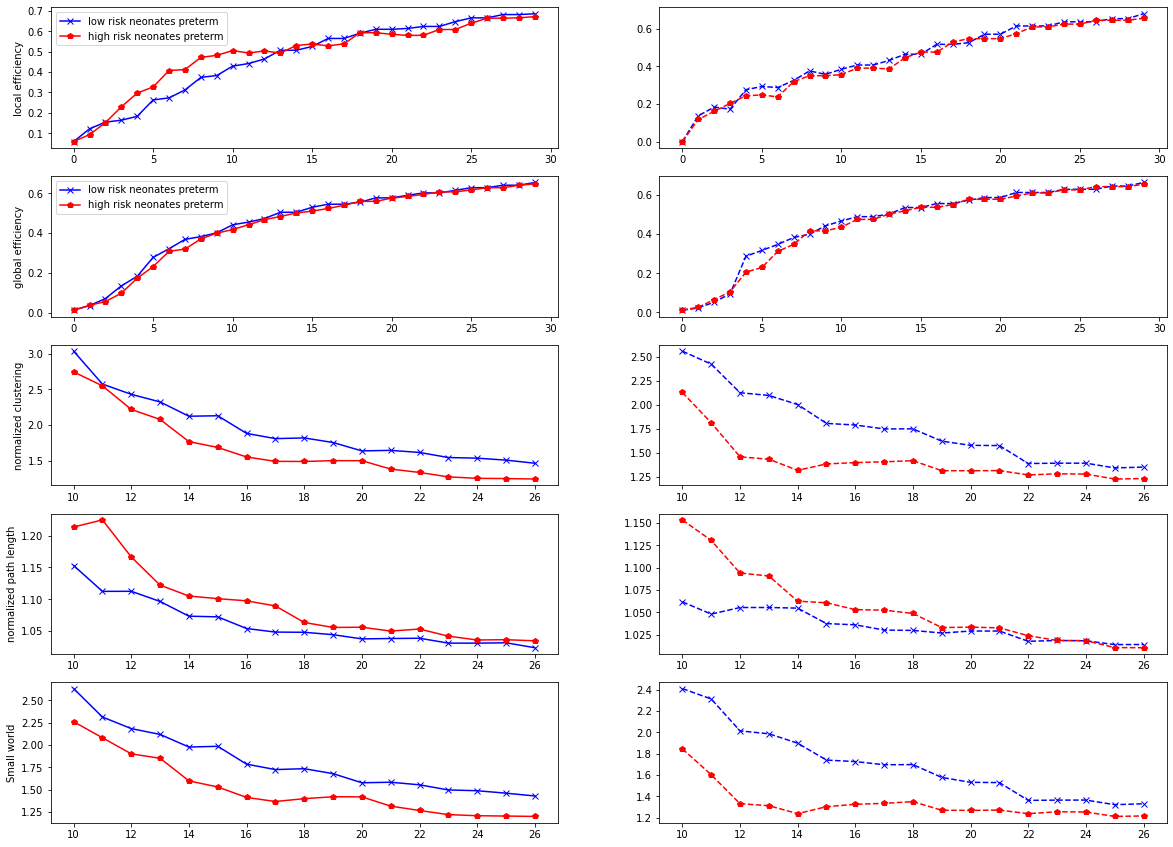

In [38]:
##############LOCAL EFFICIENCY############################
f,axes=plt.subplots(5,2,figsize=(20,15))
axes[0][0].plot(obsv_low_preterm[:,0],'x-',color='blue',label='low risk neonates preterm')
axes[0][0].plot(obsv_high_preterm[:,0],'p-',color='red',label='high risk neonates preterm')

axes[0][1].plot(obsv_low_term[:,0],'x--',color='blue',label='low risk neonates term')
axes[0][1].plot(obsv_high_term[:,0],'p--',color='red',label='high risk neonates term')

# for idx in sig_indices_local_eff:
#     axes[0][0].annotate(' ',xy=(idx,obsv_high[:,0][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[0][0].legend(loc='bottom right')
axes[0][0].set_ylabel('local efficiency')
# axes[0][0].set_ylabel('efficency measure',fontsize=18)
##############GLOBAL EFFICIENCY############################
axes[1][0].plot(obsv_low_preterm[:,1],'x-',color='blue',label='low risk neonates preterm')
axes[1][0].plot(obsv_high_preterm[:,1],'p-',color='red',label='high risk neonates preterm')

axes[1][1].plot(obsv_low_term[:,1],'x--',color='blue',label='low risk neonates term')
axes[1][1].plot(obsv_high_term[:,1],'p--',color='red',label='high risk neonates term')

# for idx in sig_indices_global_eff:
#     axes[0][1].annotate(' ',xy=(idx,obsv_high[:,1][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[1][0].legend(loc='bottom right')
axes[1][0].set_ylabel('global efficiency')
# axes[0][1].set_ylabel('efficency measure',fontsize=18)
##############NORMALIZED CLUSTERING############################
axes[2][0].plot(np.linspace(10,26,17),obsv_low_preterm[9:26,2],'x-',color='blue',label='low risk neonates')
axes[2][0].plot(np.linspace(10,26,17),obsv_high_preterm[9:26,2],'p-',color='red',label='high risk neonates')

axes[2][1].plot(np.linspace(10,26,17),obsv_low_term[9:26,2],'x--',color='blue',label='low risk neonates')
axes[2][1].plot(np.linspace(10,26,17),obsv_high_term[9:26,2],'p--',color='red',label='high risk neonates')

# for idx in sig_indices_clus_eff:
#     if idx==0:
#         continue
#     axes[1][0].annotate(' ',xy=(idx,obsv_high[:,2][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[2][0].set_ylabel('normalized clustering')
# axes[1][0].set_ylabel('efficency measure',fontsize=18)
# ##############NORMALIZED PATH############################
axes[3][0].plot(np.linspace(10,26,17),obsv_low_preterm[9:26,3],'x-',color='blue',label='low risk neonates')
axes[3][0].plot(np.linspace(10,26,17),obsv_high_preterm[9:26,3],'p-',color='red',label='high risk neonates')

axes[3][1].plot(np.linspace(10,26,17),obsv_low_term[9:26,3],'x--',color='blue',label='low risk neonates')
axes[3][1].plot(np.linspace(10,26,17),obsv_high_term[9:26,3],'p--',color='red',label='high risk neonates')

# for idx in sig_indices_path_eff:
#     if idx==0:
#         continue
#     axes[1][1].annotate(' ',xy=(idx,obsv_high[:,3][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[3][0].set_ylabel('normalized path length')
# axes[1][1].set_ylabel('efficency measure',fontsize=18)
##############SMALL WORDNESS############################
axes[4][0].plot(np.linspace(10,26,17),obsv_low_preterm[9:26,4],'x-',color='blue',label='low risk neonates')
axes[4][0].plot(np.linspace(10,26,17),obsv_high_preterm[9:26,4],'p-',color='red',label='high risk neonates')

axes[4][1].plot(np.linspace(10,26,17),obsv_low_term[9:26,4],'x--',color='blue',label='low risk neonates')
axes[4][1].plot(np.linspace(10,26,17),obsv_high_term[9:26,4],'p--',color='red',label='high risk neonates')

# for idx in sig_indices_small_eff:
#     if idx==0:
#         continue
#     axes[1][2].annotate(' ',xy=(idx,obsv_high[:,4][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[4][0].set_ylabel('Small world')
# axes[1][2].set_ylabel('efficency measure',fontsize=18)

# f.delaxes(ax=axes[0,2])

### 2.1 AAL atlas

In [19]:
#Dividing the data set into high and low risk
#get the indices of the low and high risk
#preterm
low_risk_preterm,high_risk_preterm=data_preprocessing.high_low_risk_divide(european_PRS_schizophrenia_preterm[:,9],bins=100,percentage=0.3)
X_low_risk_preterm=adjusted_european_volumetric_AAL_matrix_preterm[low_risk_preterm,:]
X_high_risk_preterm=adjusted_european_volumetric_AAL_matrix_preterm[high_risk_preterm,:]
X_preterm=np.vstack((X_low_risk_preterm,X_high_risk_preterm))
X_preterm=StandardScaler().fit_transform(X_preterm)
y_preterm=np.concatenate((np.zeros(X_low_risk_preterm.shape[0]),np.ones(X_high_risk_preterm.shape[0])))
#term
low_risk_term,high_risk_term=data_preprocessing.high_low_risk_divide(european_PRS_schizophrenia_term[:,9],bins=100,percentage=0.3)
X_low_risk_term=adjusted_european_volumetric_AAL_matrix_term[low_risk_term,:]
X_high_risk_term=adjusted_european_volumetric_AAL_matrix_term[high_risk_term,:]
X_term=np.vstack((X_low_risk_term,X_high_risk_term))
X_term=StandardScaler().fit_transform(X_term)
y_term=np.concatenate((np.zeros(X_low_risk_term.shape[0]),np.ones(X_high_risk_term.shape[0])))

In [22]:
! ls preprocessed_data/preterm/

AAL_label.npy
Imperial_GM_labels.npy
adjusted_european_GM_volumetric_Imperial_matrix.npy
adjusted_european_PRS_schizophrenia.npy
adjusted_european_volumetric_AAL_matrix.npy
adjusted_european_volumetric_Imperial_matrix.npy
european_PRS_schizophrenia.npy
european_age_at_scan.npy
european_gestational_age.npy
european_icv.npy
graph_metrics_vol_high_risk_AAL.txt
graph_metrics_vol_high_risk_Imperial.txt
graph_metrics_vol_low_risk_AAL.txt
graph_metrics_vol_low_risk_Imperial.txt
high_low_risk_vol_AAL_dataset.npy
high_low_risk_vol_Imperial_dataset.npy


In [21]:
np.save('./preprocessed_data/preterm/high_low_risk_vol_AAL_dataset.npy',X_preterm)
np.save('./preprocessed_data/term/high_low_risk_vol_AAL_dataset.npy',X_term)

### 2.2 Visualising

In [23]:
#rearrange the matrix by side
right_indices=np.array([idx for idx,i in enumerate(AAL_label) if '_R' in i])
print(right_indices.shape)
left_indices=np.array([idx for idx,i in enumerate(AAL_label) if '_L' in i])
left_indices=np.delete(left_indices,np.where(left_indices==69)[0])#removed the paracentral_lobuble_r
print(left_indices.shape)
neither_indices=np.array([idx for idx,i in enumerate(AAL_label) if '_R' not in i and '_L' not in i])
rearrange_by_side_indices=np.concatenate((right_indices,left_indices,neither_indices),axis=0)

(46,)
(46,)


In [24]:
# calculating pearson correlation matrix of volumetric data
# calculating pearson correlation matrix of volumetric data
corrmatrix_low_risk_preterm=abs(np.corrcoef(X_preterm[y_preterm==0,:],rowvar=False))
np.fill_diagonal(corrmatrix_low_risk_preterm,0)
corrmatrix_high_risk_preterm=abs(np.corrcoef(X_preterm[y_preterm==1,:],rowvar=False))
np.fill_diagonal(corrmatrix_high_risk_preterm,0)

corrmatrix_low_risk_term=abs(np.corrcoef(X_term[y_term==0,:],rowvar=False))
np.fill_diagonal(corrmatrix_low_risk_term,0)
corrmatrix_high_risk_term=abs(np.corrcoef(X_term[y_term==1,:],rowvar=False))
np.fill_diagonal(corrmatrix_high_risk_term,0)


In [25]:
rearranged_corrmatrix_low_risk_preterm=np.asarray([[corrmatrix_low_risk_preterm[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_high_risk_preterm=np.asarray([[corrmatrix_high_risk_preterm[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_low_risk_term=np.asarray([[corrmatrix_low_risk_term[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_high_risk_term=np.asarray([[corrmatrix_high_risk_term[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

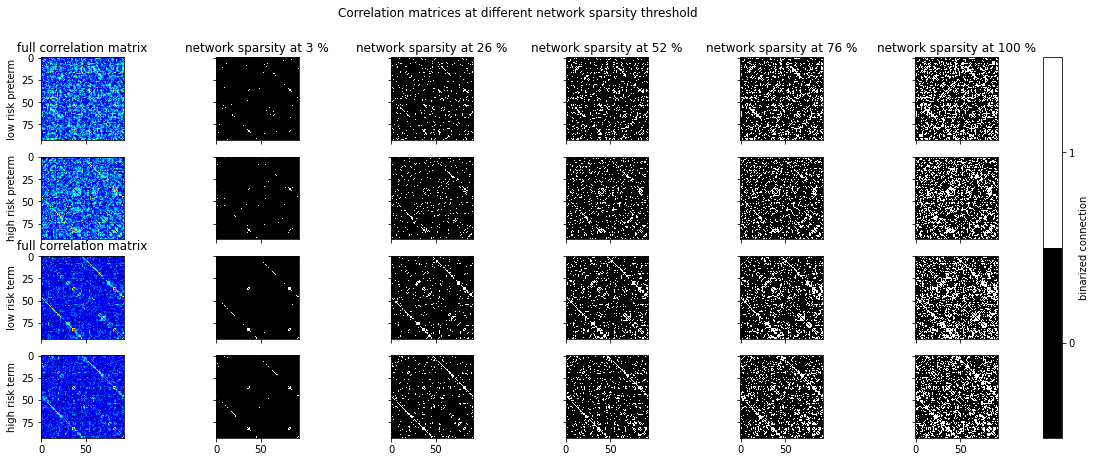

In [27]:
f,axes=plt.subplots(4,6,sharex=True,sharey=True,figsize=(20,7))
network_sparsity_threshold=[int(i) for i in (np.linspace(1,30,5))]
for idx,ax in enumerate(axes[0]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_low_risk_preterm,cmap='jet')
        ax.set_title('full correlation matrix')
        ax.set_ylabel('low risk preterm',fontsize=10)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_low_risk_preterm,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        ax.set_title('network sparsity at %d %%'%(len(np.where(data_preprocessing.lower_triangle(binarized_matrix)==1)[0])*100/(52*51/2)))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[1]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_high_risk_preterm,cmap='jet')
        ax.set_ylabel('high risk preterm',fontsize=10)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_high_risk_preterm,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

for idx,ax in enumerate(axes[2]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_low_risk_term,cmap='jet')
        ax.set_title('full correlation matrix')
        ax.set_ylabel('low risk term',fontsize=10)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_low_risk_term,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[3]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_high_risk_term,cmap='jet')
        ax.set_ylabel('high risk term',fontsize=10)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_high_risk_term,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

f.suptitle('Correlation matrices at different network sparsity threshold')
f.colorbar(im,ax=np.concatenate(axes),ticks=range(2),label='binarized connection',fraction=0.046, pad=0.04)

In [28]:
#generate binarized matrices for over a range of network sparsity for high and low risk groups
binarized_low_risk_matrices_preterm=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_low_risk_preterm,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])
binarized_high_risk_matrices_preterm=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_high_risk_preterm,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])


binarized_low_risk_matrices_term=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_low_risk_term,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])
binarized_high_risk_matrices_term=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_high_risk_term,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])

In [29]:
# #calculating graph_metrics_low_risk
# import tqdm

# for threshold in tqdm.tqdm(range(30)):
#     temp_path_low_risk='./preprocessed_data/preterm/graph_metrics_vol_low_risk_AAL.txt'
#     low_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_low_risk_matrices[threshold],51))

#     with open(temp_path_low_risk,'ab') as f:
#         np.savetxt(f,np.asarray([low_risk_metrics]),delimiter='\t')

#     temp_path_high_risk='./preprocessed_data/preterm/graph_metrics_vol_high_risk_AAL.txt'
#     high_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_high_risk_matrices[threshold],51))

#     with open(temp_path_high_risk,'ab') as n:
#         np.savetxt(n,np.asarray([high_risk_metrics]),delimiter='\t')

import tqdm

for threshold in tqdm.tqdm(range(30)):
    temp_path_low_risk='./preprocessed_data/term/graph_metrics_vol_low_risk_AAL.txt'
    low_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_low_risk_matrices_term[threshold],51))

    with open(temp_path_low_risk,'ab') as f:
        np.savetxt(f,np.asarray([low_risk_metrics]),delimiter='\t')

    temp_path_high_risk='./preprocessed_data/term/graph_metrics_vol_high_risk_AAL.txt'
    high_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_high_risk_matrices_term[threshold],51))

    with open(temp_path_high_risk,'ab') as n:
        np.savetxt(n,np.asarray([high_risk_metrics]),delimiter='\t')

100%|██████████| 30/30 [03:06<00:00,  6.22s/it]


In [39]:
#run executable_script/perm_graph_network.py to calculate 1000 permuted network metrics.
obsv_high_preterm=np.loadtxt('./preprocessed_data/preterm/graph_metrics_vol_high_risk_AAL.txt')
obsv_low_preterm=np.loadtxt('./preprocessed_data/preterm/graph_metrics_vol_low_risk_AAL.txt')

obsv_high_term=np.loadtxt('./preprocessed_data/term/graph_metrics_vol_high_risk_AAL.txt')
obsv_low_term=np.loadtxt('./preprocessed_data/term/graph_metrics_vol_low_risk_AAL.txt')

In [15]:
import glob
perm_high,perm_low=graph_analysis.preprocess_perm_graph_results(shape=(-1,30,5),high_risk=sorted(glob.glob('./log/*high*run*')),low_risk=sorted(glob.glob('./log/*low*run*')))

the two list do not have the same length: ./log/perm_graph_metrics_AAL_high_risk_vm4_run1.txt and ./log/perm_graph_metrics_AAL_low_risk_vm4_run1.txt


In [17]:
p_value_matrix=graph_analysis.calculate_perm_p_value(obsv_high,obsv_low,perm_high,perm_low)

In [18]:
sig_indices_local_eff=np.where(p_value_matrix[:,0]<=0.025)[0]
sig_indices_global_eff=np.where(p_value_matrix[:,1]<=0.025)[0]
sig_indices_clus_eff=np.where(p_value_matrix[:,2]<=0.025)[0]
sig_indices_path_eff=np.where(p_value_matrix[:,3]<=0.025)[0]
sig_indices_small_eff=np.where(p_value_matrix[:,4]<=0.025)[0]

Text(0, 0.5, 'Small world')

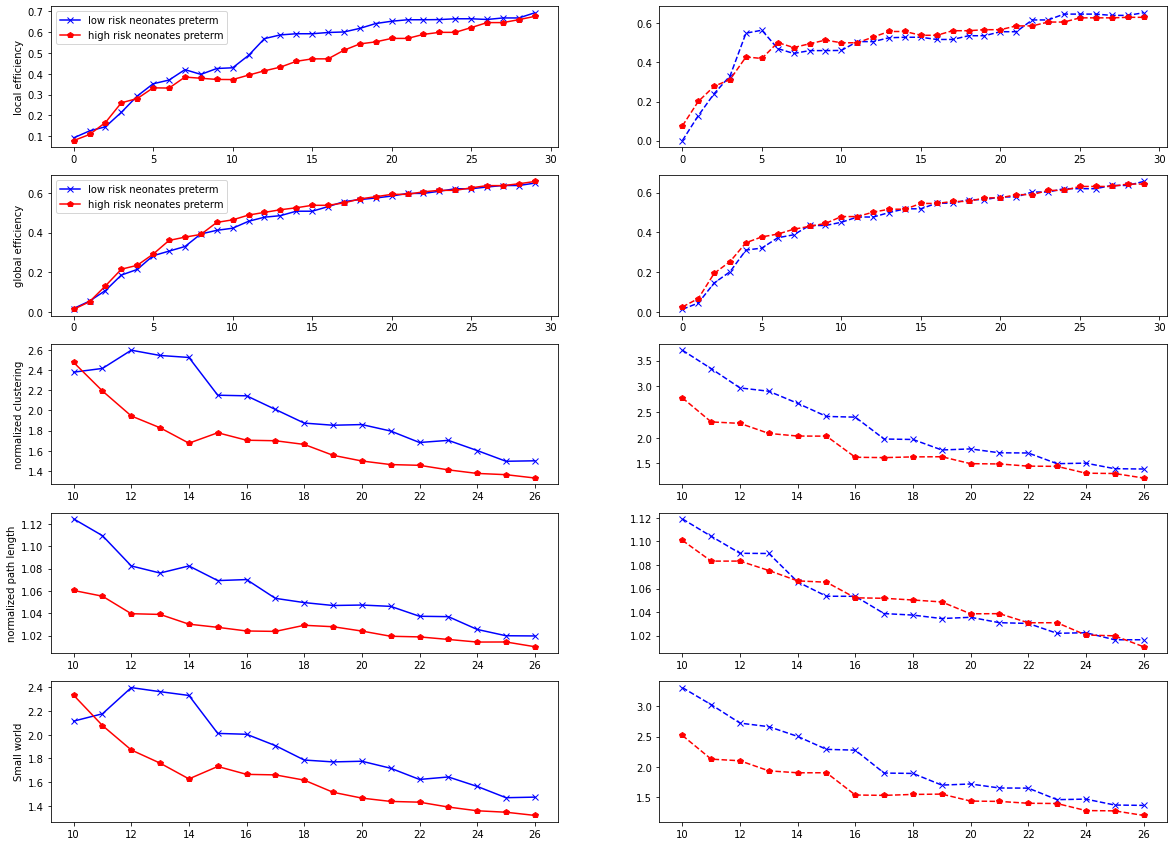

In [41]:
##############LOCAL EFFICIENCY############################
f,axes=plt.subplots(5,2,figsize=(20,15))
axes[0][0].plot(obsv_low_preterm[:,0],'x-',color='blue',label='low risk neonates preterm')
axes[0][0].plot(obsv_high_preterm[:,0],'p-',color='red',label='high risk neonates preterm')

axes[0][1].plot(obsv_low_term[:,0],'x--',color='blue',label='low risk neonates term')
axes[0][1].plot(obsv_high_term[:,0],'p--',color='red',label='high risk neonates term')

# for idx in sig_indices_local_eff:
#     axes[0][0].annotate(' ',xy=(idx,obsv_high[:,0][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[0][0].legend(loc='bottom right')
axes[0][0].set_ylabel('local efficiency')
# axes[0][0].set_ylabel('efficency measure',fontsize=18)
##############GLOBAL EFFICIENCY############################
axes[1][0].plot(obsv_low_preterm[:,1],'x-',color='blue',label='low risk neonates preterm')
axes[1][0].plot(obsv_high_preterm[:,1],'p-',color='red',label='high risk neonates preterm')

axes[1][1].plot(obsv_low_term[:,1],'x--',color='blue',label='low risk neonates term')
axes[1][1].plot(obsv_high_term[:,1],'p--',color='red',label='high risk neonates term')

# for idx in sig_indices_global_eff:
#     axes[0][1].annotate(' ',xy=(idx,obsv_high[:,1][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[1][0].legend(loc='bottom right')
axes[1][0].set_ylabel('global efficiency')
# axes[0][1].set_ylabel('efficency measure',fontsize=18)
##############NORMALIZED CLUSTERING############################
axes[2][0].plot(np.linspace(10,26,17),obsv_low_preterm[9:26,2],'x-',color='blue',label='low risk neonates')
axes[2][0].plot(np.linspace(10,26,17),obsv_high_preterm[9:26,2],'p-',color='red',label='high risk neonates')

axes[2][1].plot(np.linspace(10,26,17),obsv_low_term[9:26,2],'x--',color='blue',label='low risk neonates')
axes[2][1].plot(np.linspace(10,26,17),obsv_high_term[9:26,2],'p--',color='red',label='high risk neonates')

# for idx in sig_indices_clus_eff:
#     if idx==0:
#         continue
#     axes[1][0].annotate(' ',xy=(idx,obsv_high[:,2][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[2][0].set_ylabel('normalized clustering')
# axes[1][0].set_ylabel('efficency measure',fontsize=18)
# ##############NORMALIZED PATH############################
axes[3][0].plot(np.linspace(10,26,17),obsv_low_preterm[9:26,3],'x-',color='blue',label='low risk neonates')
axes[3][0].plot(np.linspace(10,26,17),obsv_high_preterm[9:26,3],'p-',color='red',label='high risk neonates')

axes[3][1].plot(np.linspace(10,26,17),obsv_low_term[9:26,3],'x--',color='blue',label='low risk neonates')
axes[3][1].plot(np.linspace(10,26,17),obsv_high_term[9:26,3],'p--',color='red',label='high risk neonates')

# for idx in sig_indices_path_eff:
#     if idx==0:
#         continue
#     axes[1][1].annotate(' ',xy=(idx,obsv_high[:,3][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[3][0].set_ylabel('normalized path length')
# axes[1][1].set_ylabel('efficency measure',fontsize=18)
##############SMALL WORDNESS############################
axes[4][0].plot(np.linspace(10,26,17),obsv_low_preterm[9:26,4],'x-',color='blue',label='low risk neonates')
axes[4][0].plot(np.linspace(10,26,17),obsv_high_preterm[9:26,4],'p-',color='red',label='high risk neonates')

axes[4][1].plot(np.linspace(10,26,17),obsv_low_term[9:26,4],'x--',color='blue',label='low risk neonates')
axes[4][1].plot(np.linspace(10,26,17),obsv_high_term[9:26,4],'p--',color='red',label='high risk neonates')

# for idx in sig_indices_small_eff:
#     if idx==0:
#         continue
#     axes[1][2].annotate(' ',xy=(idx,obsv_high[:,4][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[4][0].set_ylabel('Small world')
# axes[1][2].set_ylabel('efficency measure',fontsize=18)

# f.delaxes(ax=axes[0,2])